In [1]:
# Move CTC_TPU for local use
from shutil import copyfile
copyfile(src = "/kaggle/input/ctc-tpu/CTC_TPU.py", dst = "/kaggle/working//CTC_TPU.py")

from CTC_TPU import classic_ctc_loss

D1006 02:13:01.181130524      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1006 02:13:01.181178107      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1006 02:13:01.181185109      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1006 02:13:01.181188635      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1006 02:13:01.181191346      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1006 02:13:01.181194035      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1006 02:13:01.181196385      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1006 02:13:01.

In [2]:
!pip install -q tensorflow-addons
!pip install -q git+https://github.com/hoyso48/tf-utils@main
!pip install -q Levenshtein
!pip install -q keras_nlp


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
"""!pip freeze > requirements.txt
!cat requirements.txt

import sys
print(f"Python version: {sys.version}")"""

'!pip freeze > requirements.txt\n!cat requirements.txt\n\nimport sys\nprint(f"Python version: {sys.version}")'

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
import keras_nlp
import tensorflow.keras.mixed_precision as mixed_precision

from tf_utils.schedules import OneCycleLR, ListedLR
from tf_utils.callbacks import Snapshot, SWA
from tf_utils.learners import FGM, AWP

import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.autonotebook import tqdm
import sklearn

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
import glob
import datetime

from Levenshtein import distance

print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

Using TensorFlow backend


/usr/local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/tmp/ipykernel_15/864907894.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Tensorflow Version: 2.12.0
Python Version: 3.8.17 (default, Jul  4 2023, 06:27:59) 
[GCC 12.2.0]


In [5]:
# Seed all random number generators
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Accelerator settings
def get_strategy(device='TPU'):
    if "TPU" in device:
        tpu = 'local' if device=='TPU-VM' else None
        print("connecting to TPU...")
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        IS_TPU = True

    if device == "GPU"  or device=="CPU":
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
        IS_TPU = False

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)

    AUTO     = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')

    return strategy, REPLICAS, IS_TPU

STRATEGY, N_REPLICAS, IS_TPU = get_strategy('TPU-VM')

connecting to TPU...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/tas

In [6]:
# Initialise tfrecord files
TRAIN_FILENAMES = tf.io.gfile.glob('/kaggle/input/ausslfr-5fold/*.tfrecords')

print(len(TRAIN_FILENAMES))

10


In [7]:
# Label dictionary
import json
from IPython.display import display

with open('/kaggle/input/australian-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR_TO_NUM = json.load(json_file)
NUM_TO_CHAR = dict([(y+1,x) for x,y in CHAR_TO_NUM.items()] )
NUM_TO_CHAR[60] = 'S'
NUM_TO_CHAR[61] = 'E'
NUM_TO_CHAR[0] = 'P'

TABLE = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(NUM_TO_CHAR.values()),
        values=list(NUM_TO_CHAR.keys()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

# Train data frame
train_df = pd.read_csv('/kaggle/input/australian-fingerspelling/train.csv')
display(train_df.head())
display(train_df.info())

,path,file_id,sequence_id,participant_id,phrase
0,landmarks/101.parquet,101,10101,1,abcdefghijklmnopqrstuvwxyz
1,landmarks/101.parquet,101,10104,1,antecedent
2,landmarks/101.parquet,101,10105,1,antifascist
3,landmarks/101.parquet,101,10106,1,cooperate
4,landmarks/101.parquet,101,10107,1,describe


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            3933 non-null   object
 1   file_id         3933 non-null   int64 
 2   sequence_id     3933 non-null   int64 
 3   participant_id  3933 non-null   int64 
 4   phrase          3933 non-null   object
dtypes: int64(3), object(2)
memory usage: 153.8+ KB


None

In [8]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename.split('/')[-1]).group(1)) for filename in filenames]
    return np.sum(n)
print(count_data_items(TRAIN_FILENAMES), len(train_df))
assert count_data_items(TRAIN_FILENAMES) == len(train_df)

3933 3933


In [9]:
#for the lip_lr function. LEFT[i] is matching with RIGHT[i](i.e LEFT[i](x) == -RIGHT[i](x)).
#computed from https://github.com/google/mediapipe/blob/master/mediapipe/modules/face_geometry/data/canonical_face_model.obj

LEFT = [
         248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
         265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
         282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
         299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
         316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
         333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
         350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366,
         367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383,
         384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400,
         401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
         418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434,
         435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451,
         452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,  #LFACE
         468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, #LHAND
         493, 494, 495, 497, 499, 501, 503, 505, 507, 509, 511, 513, #LPOSE
         515, 517, 519, 521, #LLEG
         ]

RIGHT = [
         3, 7, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
         39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
         60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
         81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102,
         103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
         121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
         139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 154, 155, 156, 157, 158,
         159, 160, 161, 162, 163, 165, 166, 167, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179,
         180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 198, 201,
         202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
         220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
         238, 239, 240, 241, 242, 243, 244, 245, 246, 247, #RFACE
        522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, #RHAND
        490, 491, 492, 496, 498, 500, 502, 504, 506, 508, 510, 512, #RPOSE
        514, 516, 518, 520, #RLEG
        ]

CENTRE = [
          0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 94, 151, 152, 164, 168, 175, 195, 197, 199, 200, #FACE
          489, #POSE
          ]

print(len(LEFT+RIGHT+CENTRE))

543


In [10]:
# Initialise variables for training
ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES  = len(NUM_TO_CHAR.values()) #62
PAD = -100.

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()
POINT_LANDMARKS = list(range(543))

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 3*NUM_NODES

print(NUM_NODES)
print(CHANNELS)

543
1629


# Function Definitions

In [11]:
def preprocess_phrase(phrase, table=TABLE):
    phrase = tf.strings.join(['S', phrase, 'E']) #'S'+ phrase + 'E'
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    return phrase

def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

def is_left_handed(x):
    lhand = tf.gather(x, LHAND, axis=1)
    rhand = tf.gather(x, RHAND, axis=1)
    lhand_nans = tf.reduce_sum(tf.cast(tf.math.is_nan(lhand), tf.int32))
    rhand_nans = tf.reduce_sum(tf.cast(tf.math.is_nan(rhand), tf.int32))
    return lhand_nans < rhand_nans

def flip_lr(x, left=LEFT, right=RIGHT):
    x,y,z = tf.unstack(x, axis=-1)
    x = 1-x
    new_x = tf.stack([x,y,z], -1)
    new_x = tf.transpose(new_x, [1,0,2])
    l_x = tf.gather(new_x, left, axis=0)
    r_x = tf.gather(new_x, right, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(left)[...,None], r_x)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(right)[...,None], l_x)
    new_x = tf.transpose(new_x, [1,0,2])
    return new_x

class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        # if tf.rank(inputs) == 3:
        #     x = inputs[None,...]
        # else:
        #     x = inputs
        x = inputs
        x = filter_nans_tf(x)
        x = tf.cond(is_left_handed(x), lambda:flip_lr(x), lambda:x)
        x = x[None,...]

        if self.max_len is not None:
            x = x[:,:self.max_len]
        length = tf.shape(x)[1]

        mean = tf_nan_mean(tf.gather(x, self.point_landmarks, axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant([0.5,0.5,0.],x.dtype), mean)
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)

        x = (x - mean)/std

        x = tf.concat([
            tf.reshape(x, (-1,length,3*len(self.point_landmarks))),
            # tf.reshape(dx, (-1,length,3*len(self.point_landmarks))),
        ], axis = -1)

        x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)

        return x

In [12]:
def decode_tfrec(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'coordinates': tf.io.FixedLenFeature([], tf.string),
        'phrase_encoded': tf.io.VarLenFeature(dtype=tf.int64),
        'phrase': tf.io.FixedLenFeature([], tf.string),
    })
    out = {}
    out['coordinates']  = tf.transpose(tf.reshape(tf.io.decode_raw(features['coordinates'], tf.float32), (-1,3,ROWS_PER_FRAME)), (0,2,1))
    out['phrase'] = features['phrase']
    return out

def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
    mask = tf.math.logical_not(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]))
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def preprocess(x, augment=False, max_len=MAX_LEN):
    coord = x['coordinates']
    if augment:
        coord = augment_fn(coord, max_len=max_len)
    coord = tf.ensure_shape(coord, (None,ROWS_PER_FRAME,3))

    inp = tf.cast(Preprocess(max_len=max_len)(coord)[0],tf.float32)
    tar = preprocess_phrase(x['phrase'])

    return inp, tar

def augment_phrase(phrase):
    phrase = keras_nlp.layers.MaskedLMMaskGenerator(NUM_CLASSES-2,
                                              mask_selection_rate=0.2,
                                              mask_token_id=0,
                                              mask_token_rate=0,
                                              random_token_rate=1,
                                              unselectable_token_ids=[0,60,61])(phrase)['token_ids']
    return phrase

def is_empty(*args):
    return tf.shape(args[0])[0] > 1

def resample(x, rate=(0.8,1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32)
    new_x = interp1d_(x, new_size)
    return new_x

def spatial_random_affine(xyz,
    scale  = (0.8,1.2),
    shear = (-0.15,0.15),
    shift  = (-0.1,0.1),
    degree = (-30,30),
):
    center = tf.constant([0.5,0.5])
    if scale is not None:
        scale = tf.random.uniform((),*scale)
        xyz = scale*xyz

    if shear is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        shear_x = shear_y = tf.random.uniform((),*shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.
        else:
            shear_y = 0.
        shear_mat = tf.identity([
            [1.,shear_x],
            [shear_y,1.]
        ])
        xy = xy @ shear_mat
        center = center + [shear_y, shear_x]
        xyz = tf.concat([xy,z], axis=-1)

    if degree is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        xy -= center
        degree = tf.random.uniform((),*degree)
        radian = degree/180*np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([
            [c,s],
            [-s, c],
        ])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy,z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((),*shift)
        xyz = xyz + shift

    return xyz

def temporal_crop(x, length=MAX_LEN):
    l = tf.shape(x)[0]
    offset = tf.random.uniform((), 0, tf.clip_by_value(l-length,1,length), dtype=tf.int32)
    x = x[offset:offset+length]
    return x

def temporal_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    l = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform((), 0, tf.clip_by_value(l-mask_size,1,l), dtype=tf.int32)
    x = tf.tensor_scatter_nd_update(x,tf.range(mask_offset, mask_offset+mask_size)[...,None],tf.fill([mask_size,543,3],mask_value))
    return x

def spatial_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    mask_offset_y = tf.random.uniform(())
    mask_offset_x = tf.random.uniform(())
    mask_size = tf.random.uniform((), *size)
    mask_x = (mask_offset_x<x[...,0]) & (x[...,0] < mask_offset_x + mask_size)
    mask_y = (mask_offset_y<x[...,1]) & (x[...,1] < mask_offset_y + mask_size)
    mask = mask_x & mask_y
    x = tf.where(mask[...,None], mask_value, x)
    return x

def augment_fn(x, always=False, max_len=None):
    if tf.random.uniform(())<0.8 or always:
        x = resample(x, (0.5,1.5))
    # if tf.random.uniform(())<0.5 or always:
    #     x = flip_lr(x)
    # if max_len is not None:
    #     x = temporal_crop(x, max_len)
    if tf.random.uniform(())<0.75 or always:
        x = spatial_random_affine(x)
    # if tf.random.uniform(())<0.5 or always:
    #     x = temporal_mask(x)
    if tf.random.uniform(())<0.5 or always:
        x = spatial_mask(x)
    return x

def get_tfrec_dataset(tfrecords, batch_size=64, max_len=128, target_len=64, teacher_forcing=True, drop_remainder=False, train=False, augment=False, shuffle=False, repeat=False):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    ds = ds.map(lambda x: preprocess(x, augment=augment, max_len=max_len), tf.data.AUTOTUNE)

    if train:
        ds = ds.filter(is_empty)

    if teacher_forcing:
        ds = ds.map(lambda x,y:((x,y[:-1]),(y[1:],y[1:-1])), tf.data.AUTOTUNE)
        if augment:
            ds = ds.map(lambda x,y:((x[0],augment_phrase(x[1])),y), tf.data.AUTOTUNE)

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)

    if batch_size:
        if teacher_forcing:
            ds = ds.padded_batch(batch_size, padding_values=((PAD,0),(0,0)), padded_shapes=(([max_len,CHANNELS],[target_len,]),([target_len,],[target_len,])), drop_remainder=drop_remainder)
        else:
            ds = ds.padded_batch(batch_size, padding_values=(PAD,0), padded_shapes=([max_len,CHANNELS],[target_len,]), drop_remainder=drop_remainder)

    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [13]:
from tensorflow.python.ops.gen_dataset_ops import filter_dataset_eager_fallback
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class MaskingDWConv1D(tf.keras.layers.Layer):
    '''
    masked DW1Dconv with strides>1, padding=same.
    NOTE: padded(masked) frames should always be at the beginning or end of the input sequence.
    '''
    def __init__(self, kernel_size, strides=1,
        dilation_rate=1,
        padding='same',
        use_bias=False,
        kernel_initializer='glorot_uniform',**kwargs):
        super().__init__(**kwargs)
        assert padding == 'same' or padding == 'causal'
        self.strides = strides
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.use_bias = use_bias
        self.padding = padding
        self.conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=strides,
                            dilation_rate=dilation_rate,
                            padding=padding,
                            use_bias=use_bias,
                            kernel_initializer=kernel_initializer)
        self.supports_masking = True

    def compute_mask(self, inputs, mask=None):
      if mask is not None:
        if self.strides > 1:
          mask = mask[:,::self.strides]
      return mask

    def call(self, inputs, mask=None):
        x = inputs
        if mask is not None:
            x = tf.where(mask[...,None], x, tf.constant(0., dtype=x.dtype))
        x = self.conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          strides=1,
          drop_rate=0.0,
          expand_ratio=2,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("conv1dblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + 'pre_bn')(inputs)

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(x)

        # Depthwise Convolution
        x = MaskingDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            strides=strides,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + 'conv_bn')(x)

        x = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size) and (strides == 1):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [14]:
class PosEmbedding(tf.keras.layers.Layer):
    def __init__(self, dim=64, max_len=64, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=max_len, output_dim=dim)
        self.supports_masking = True

    def call(self, x, positions=None):
        if positions is None:
            maxlen = tf.shape(x)[1]
            positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.q = tf.keras.layers.Dense(dim, use_bias=False)
        self.k = tf.keras.layers.Dense(dim, use_bias=False)
        self.v = tf.keras.layers.Dense(dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def get_causal_mask(self, q, k):
        q_len = tf.shape(q)[1]
        k_len = tf.shape(k)[1]
        i = tf.range(q_len)[:, None]
        j = tf.range(k_len)
        mask = i >= j
        mask = tf.reshape(mask, (q_len, k_len))
        return mask

    def merge_input_state(self, input, state, layer):
        if input is not None and state is not None:
            return tf.keras.layers.Concatenate(axis=1)([state, layer(input)])
        elif input is not None and state is None:
            return layer(input)
        elif input is None and state is not None:
            return state
        else:
            raise ValueError

    def call(self, q, k=None, v=None, key_state=None, value_state=None, return_states=False, use_causal_mask=False):
        q = self.q(q)
        k = self.merge_input_state(k, key_state, self.k)
        v = self.merge_input_state(v, value_state, self.v)
        mask = getattr(k, '_keras_mask', None) # we only consider mask from the 'key' here.
        if mask is not None:
            mask = mask[:,None,None,:]
        if use_causal_mask:
            if mask is not None:
                mask = tf.logical_and(mask, self.get_causal_mask(q,k)[None,None,:,:])
            else:
                mask = self.get_causal_mask(q,k)[None,None,:,:]
        q_ = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim // self.num_heads))(q))
        k_ = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim // self.num_heads))(k))
        v_ = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim // self.num_heads))(v))
        attn = tf.matmul(q_, k_, transpose_b=True) * self.scale

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v_
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        if return_states:
            return x, k, v
        else:
            return x

def TransformerDecoderBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0., activation='swish', name=None):
    if name is None:
        name = str(tf.keras.backend.get_uid("transformerdecoderblock"))
    def apply(q,k,v):
        x = q
        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn1')(x)
        x = MultiHeadAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout, name=name + '_self_attn')(x,x,x,use_causal_mask=True)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop1')(x)
        x = tf.keras.layers.Add(name=name + '_add1')([q, x])
        attn_out1 = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn2')(x)
        x = MultiHeadAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout, name=name + '_cross_attn')(x,k,v)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop2')(x)
        x = tf.keras.layers.Add(name=name + '_add2')([attn_out1, x])
        attn_out2 = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn3')(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation, name=name + '_fc1')(x)
        x = tf.keras.layers.Dense(dim, use_bias=False, name=name + '_fc2')(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop3')(x)
        x = tf.keras.layers.Add(name=name + '_add3')([attn_out2, x])
        return x
    return apply


class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x

def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish', name=None):
    if name is None:
        name = str(tf.keras.backend.get_uid("transformerblock"))
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn1')(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout, name=name + '_mhsa')(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop1')(x)
        x = tf.keras.layers.Add(name=name + '_add1')([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + 'bn2')(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation, name=name + '_fc1')(x)
        x = tf.keras.layers.Dense(dim, use_bias=False, name=name + '_fc2')(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop2')(x)
        x = tf.keras.layers.Add(name=name + '_add2')([attn_out, x])
        return x
    return apply

In [15]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, blank_index=0, input_padding_value=0., target_padding_value=0, **kwargs):
        super().__init__(**kwargs)
        self.blank_index = blank_index
        self.input_padding_value = input_padding_value
        self.target_padding_value = target_padding_value

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        batch_len = tf.cast(tf.shape(y_true)[0], dtype=tf.int32)
        label_length = y_true != tf.cast(self.target_padding_value, tf.int32)
        label_length = tf.reduce_sum(tf.cast(label_length, tf.int32), axis=1, keepdims=False) #(B,)
        mask = getattr(y_pred, '_keras_mask', None)
        if mask is not None:
            input_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=-1)
        else:
            input_length = tf.cast(tf.shape(y_pred)[1], dtype=tf.int32)
            input_length = input_length * tf.ones(shape=(batch_len,), dtype=tf.int32)

        # loss = tf.nn.ctc_loss(y_true, y_pred, label_length=label_length, logit_length=input_length, blank_index=0, logits_time_major=False)
        loss = classic_ctc_loss(y_true, y_pred, label_length=label_length, logit_length=input_length, blank_index=0) #only for the kaggle TPU

        loss = tf.reduce_mean(loss)

        return loss

class MaskedSCCE(tf.keras.losses.Loss):
    def __init__(self, num_classes=NUM_CLASSES, from_logits=True, label_smoothing=0.25, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.label_smoothing=label_smoothing
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        mask = y_true!=0
        N = tf.shape(y_true)[0]
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.one_hot(y_true, self.num_classes, axis=-1, dtype=tf.float32)
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits, label_smoothing=self.label_smoothing)
        loss = tf.where(mask, loss, tf.constant(0, dtype=tf.float32))
        loss = tf.reduce_sum(loss)
        loss = loss / tf.cast(N, tf.float32)
        return loss

class Accuracy(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(Accuracy, self).__init__(name=f'acc', **kwargs)
        self.acc = tf.keras.metrics.SparseCategoricalAccuracy()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        mask = y_true != 0
        y_true = tf.boolean_mask(y_true, mask)
        y_pred = tf.boolean_mask(y_pred, mask)
        self.acc.update_state(y_true, y_pred)

    def result(self):
        return self.acc.result()

    def reset_state(self):
        self.acc.reset_state()

In [16]:
class GreedyDecoder(tf.keras.layers.Layer):
    def __init__(self, model, max_output_length=64, sos_token_idx=60, eos_token_idx=61, pad_token_idx=0, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.encoder = self.model.get_layer('encoder')
        self.decoder = self.model.get_layer('att_decoder')
        self.inference_module = self.model.get_layer('att_decoder')
        self.max_output_length = max_output_length
        self.sos_token_idx = sos_token_idx
        self.eos_token_idx = eos_token_idx
        self.pad_token_idx = pad_token_idx

    def call(self, batch_x):
        encoder_out = self.encoder(batch_x)

        time = tf.constant(0, dtype=tf.int32)
        predictions = tf.ones((tf.shape(batch_x)[0],1), dtype=tf.int32) * self.sos_token_idx
        pad = tf.ones((tf.shape(batch_x)[0],), dtype=tf.int32) * self.pad_token_idx
        init = True

        def condition(_time, _predictions):
            return tf.logical_and(_time < self.max_output_length, tf.logical_not(tf.reduce_all(tf.reduce_any(_predictions==self.eos_token_idx, axis=1))))

        def body(_time, _predictions):
            out = self.inference_module([_predictions, encoder_out])
            pred_curr = tf.where(tf.reduce_any(_predictions==self.eos_token_idx, axis=1), [self.pad_token_idx], tf.argmax(out[:,-1], axis=-1, output_type=tf.int32))
            _predictions = tf.concat([_predictions, pred_curr[...,None]], axis=1)
            return _time+1, _predictions

        _, predictions = tf.while_loop(condition, body, loop_vars=[time, predictions])
        return predictions[:,1:]

class KerasCTCDecoder(tf.keras.layers.Layer):
    def __init__(self, model, greedy=True, beam_width=100, from_logits=True, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.greedy = greedy
        self.beam_width = beam_width
        self.from_logits = from_logits
        self.encoder = self.model.get_layer('encoder')
        self.ctc_decoder = self.model.get_layer('ctc_decoder')

    def call(self, batch_x):
        encoder_out = self.encoder(batch_x)
        input_length = tf.reduce_sum(tf.cast(encoder_out._keras_mask, tf.int32), axis=1)
        predictions = self.ctc_decoder(encoder_out)
        if not self.greedy and self.from_logits:
            predictions = tf.nn.softmax(predictions, axis=-1)
        predictions = tf.keras.backend.ctc_decode(tf.cast(predictions, tf.float32), input_length=input_length, greedy=self.greedy, beam_width=self.beam_width)[0][0]
        return predictions

In [17]:
def make_predictions(recognizer, ds):
    results = []
    for batch in tqdm(ds):
        result = recognizer(batch[0][0])
        results.append(num_to_char(result.numpy()))
    results = np.array([item for sublist in results for item in sublist])
    return results

def num_to_char(list_of_nums, n2c_dict=NUM_TO_CHAR):
    def n_to_c(x):
        return [n2c_dict[a] for a in x if a!=-1]
    char_list = [''.join(n_to_c(x)).replace('P','').replace('S','').replace('E','') for x in list_of_nums]
    return np.array(char_list, dtype='str')

def extract_labels(ds):
    labels = [num_to_char(x[1][0].numpy()) for x in ds]
    labels = np.array([item for sublist in labels for item in sublist])
    return labels

from Levenshtein import distance
def competition_metric(true, pred):
    #true: list of strings, ground truths
    #pred: list of strings, predictions
    D = sum([distance(x,y) for x,y in zip(true, pred)])
    N = len(''.join(true))
    return max((N-D)/N, 0.), D/len(true)

def display(labels, preds):
    for target,prediction in zip(labels, preds):
        print(f"Target    : {target}")
        print(f"Prediction: {prediction}")
        print("-" * 100)
    return

def evaluate(model, ds, labels=None, display_index='random', num_display=5):
    if labels is None:
        labels = extract_labels(ds)
    preds = make_predictions(model, ds)
    score, mean_dist = competition_metric(labels, preds)
    num_display = min(len(labels), num_display)
    if display_index=='random':
        if num_display:
            idxs = np.random.choice(range(len(labels)),num_display,replace=False)
            display(labels[idxs], preds[idxs])
    elif display_index=='init':
        if num_display:
            display(labels[:num_display], preds[:num_display])
    elif isinstance(display_index, list):
        if display_index:
            display(labels[display_index], preds[display_index])
    else:
        pass
    print(f'Score: {score:0.4f}')
    print(f'mean_dist: {mean_dist:0.4f}')
    # return labels, preds, score
    del preds, score
    return

class Eval(tf.keras.callbacks.Callback):
    def __init__(self,recognizer,ds,labels=None,eval_epochs=[],display_index='random',num_display=5):
        super().__init__()
        self.recognizer = recognizer
        self.ds = ds
        self.labels = labels
        self.eval_epochs = eval_epochs
        self.display_index = display_index
        self.num_display = num_display

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.eval_epochs and self.ds is not None: # your custom condition
            evaluate(self.recognizer, self.ds, self.labels, self.display_index, self.num_display)

In [18]:
class AWP(tf.keras.Model):
    def __init__(self, *args, lr=0.1, eps=1e-6, start_step=0, exclude=[], **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
        self.eps = eps
        self.start_step = start_step
        self.exclude = exclude

    def compute_perturbation(self, param, param_gradient):
        grad = tf.zeros_like(param) + param_gradient
        #delta = tf.math.divide_no_nan(self.lr * grad * tf.norm(param), tf.norm(grad) + self.eps) #original implemenation from the paper
        delta = tf.math.divide_no_nan(self.lr * grad, tf.norm(grad) + self.eps)
        return delta

    def train_step_awp(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        params = self.trainable_variables
        params_gradients = tape.gradient(loss, self.trainable_variables)

        for i in range(len(params_gradients)):
            if not any(s in params[i].name for s in self.exclude):
                delta = self.compute_perturbation(params[i], params_gradients[i])
                self.trainable_variables[i].assign_add(delta)

        with tf.GradientTape() as tape2:
            y_pred = self(x, training=True)
            new_loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            if hasattr(self.optimizer, 'get_scaled_loss'):
                new_loss = self.optimizer.get_scaled_loss(new_loss)

        gradients = tape2.gradient(new_loss, self.trainable_variables)
        if hasattr(self.optimizer, 'get_unscaled_gradients'):
            gradients =  self.optimizer.get_unscaled_gradients(gradients)

        for i in range(len(params_gradients)):
            if not any(s in params[i].name for s in self.exclude):
                delta = self.compute_perturbation(params[i], params_gradients[i])
                self.trainable_variables[i].assign_sub(delta)

        #if nan is detected, skip update
        # nan_detected = tf.reduce_any([tf.reduce_any(tf.math.is_nan(g)) for g in gradients])
        # _ = tf.cond(nan_detected, lambda:tf.constant(False),lambda:self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)))

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def train_step(self, data):
        return tf.cond(self._train_counter < self.start_step, lambda:super(AWP,self).train_step(data), lambda:self.train_step_awp(data))

In [19]:
def get_model(max_len=128, target_len=64, dim=192, dtype='float32'):
    ################# ENCODER #################
    inp1 = tf.keras.Input((max_len,CHANNELS),dtype=dtype)
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp1)
    ksize = 17
    drop_rate = 0.2
    x = tf.keras.layers.Dense(dim,use_bias=False,name='stem_conv')(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = TransformerBlock(dim,expand=2,num_heads=4,drop_rate=drop_rate,attn_dropout=0.2)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = TransformerBlock(dim,expand=2,num_heads=4,drop_rate=drop_rate,attn_dropout=0.2)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=0,strides=2)(x) #drop_rate=0 since we don't want to drop the whole output here
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = TransformerBlock(dim,expand=2,num_heads=4,drop_rate=drop_rate,attn_dropout=0.2)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = Conv1DBlock(dim,ksize,expand_ratio=4,drop_rate=drop_rate)(x)
    x = TransformerBlock(dim,expand=2,num_heads=4,drop_rate=drop_rate,attn_dropout=0.2)(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)

    encoder = tf.keras.Model(inp1,x,name='encoder')

    ################# CTC DECDODER #################
    inp3 = tf.keras.Input((x.shape[1],dim),name='ctc_decoder_inp2',dtype=dtype)
    x = inp3
    x = tf.keras.layers.RNN(tf.keras.layers.GRUCell(dim), return_sequences=True)(x)
    x = tf.keras.layers.Dense(dim*2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='ctc_classifier')(x) #include sos, eos token
    ctc_decoder = tf.keras.Model(inp3,x,name='ctc_decoder')

    ################# ATT DECODER #################
    inp2 = tf.keras.Input((None,),name='att_decoder_inp1',dtype='int32')
    inp3 = tf.keras.Input((x.shape[1],dim),name='att_decoder_inp2',dtype=dtype)

    x = inp3
    y = tf.keras.layers.Masking(mask_value=0,input_shape=(None,),name='att_decoder_input_masking')(inp2)
    y = tf.keras.layers.Embedding(NUM_CLASSES,dim,mask_zero=True,name='att_decoder_token_emb')(y) #include sos token
    y = PosEmbedding(dim,max_len=target_len,name='att_decoder_pos_emb')(y)
    y = TransformerDecoderBlock(dim,expand=2,num_heads=4,attn_dropout=0.2,name='att_decoder_block1')(y,x,x)
    y = tf.keras.layers.Dropout(0.5)(y)
    y = tf.keras.layers.Dense(NUM_CLASSES,name='att_decoder_classifier')(y)

    decoder = tf.keras.Model([inp2,inp3],y,name='att_decoder')

    ################### MODEL #####################
    inp1 = tf.keras.Input((max_len,CHANNELS),dtype=dtype)
    inp2 = tf.keras.Input((None,),dtype='int32')

    x = inp1
    enc_out = encoder(x)
    y = inp2
    dec_out = decoder([y, enc_out])
    ctc_out = ctc_decoder(enc_out)
    model = tf.keras.Model([inp1,inp2], [dec_out,ctc_out])

    return model

In [20]:
class CSVLoggerV2(tf.keras.callbacks.CSVLogger):
    def __init__(self, filename, separator=",", resume=0):
        self.resume = resume
        super().__init__(filename=filename, separator=separator, append=bool(resume))

    def on_epoch_end(self, epoch, logs=None):
        super(CSVLoggerV2,self).on_epoch_end(epoch=epoch+self.resume+1, logs=logs)

In [21]:
def train_fold(CFG, fold, train_files, valid_files=None, strategy=STRATEGY, summary=True):
    seed_everything(CFG.seed)
    tf.keras.backend.clear_session()
    gc.collect()
    # tf.config.optimizer.set_jit(True)

    policy = mixed_precision.Policy(CFG.policy)
    mixed_precision.set_global_policy(policy)

    if CFG.resume == 'auto':
        if os.path.isfile(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv'):
            resume = pd.read_csv(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv')['epoch'].values[-1]
            resume = 0 if resume == CFG.epoch else resume #restart if training is already fininshed
        else:
            resume = 0
    else:
        resume = CFG.resume

    if fold != 'all':
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.train_batch_size, max_len=CFG.max_len, drop_remainder=True, train=True, augment=True, repeat=True, shuffle=4096)
        valid_ds = get_tfrec_dataset(valid_files, batch_size=CFG.valid_batch_size, max_len=CFG.max_len, drop_remainder=True, repeat=False, shuffle=False)
    else:
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.train_batch_size, max_len=CFG.max_len, drop_remainder=True, train=True, augment=True, repeat=True, shuffle=4096)
        valid_ds = None
        valid_files = []

    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files)
    steps_per_epoch = num_train//CFG.train_batch_size
    with strategy.scope():
        model = get_model(max_len=CFG.max_len, dim=CFG.dim, dtype='bfloat16') #dtype should be matched with CFG.policy

        schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type=CFG.warmup_type)
        decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type=CFG.warmup_type)

        awp_start_epoch = max(CFG.awp_start_epoch - resume, 0)
        awp_step = int(awp_start_epoch * steps_per_epoch)
        if CFG.fgm:
            model = FGM(model.input, model.output, lr=CFG.awp_lr, eps=0., start_step=awp_step)
        elif CFG.awp:
            model = AWP(model.input, model.output, lr=CFG.awp_lr, eps=0., start_step=awp_step, exclude=['bias','gamma','beta','rnn'])

        # opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)
        # opt = tfa.optimizers.Lookahead(opt,sync_period=5)
        opt = tfa.optimizers.AdamW(learning_rate=schedule, weight_decay=decay_schedule)

        model.compile(
            optimizer=opt,
            loss=[MaskedSCCE(label_smoothing=0.25), CTCLoss()],
            loss_weights=[0.75,0.25],
            metrics=[
                [
                Accuracy(),
                ],
                [],
            ],
        )

    if summary:
        print()
        model.summary()
        print()
        print(train_ds, valid_ds)
        print()
        schedule.plot()
        print()
        init=False
    print(f'---------fold{fold}---------')
    print(f'train:{num_train} valid:{num_valid}')
    print()

    if resume:
        print(f'resume from epoch{resume}')
        if CFG.resume_ckpt:
            print(f'load weights from {CFG.resume_ckpt}')
            model.load_weights(CFG.resume_ckpt)
        else:
            print(f'load weights from {CFG.output_dir}/{CFG.comment}-fold{fold}-last.h5')
            model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-last.h5')
        # if train_ds is not None:
        #     model.evaluate(train_ds.take(steps_per_epoch))
        # if valid_ds is not None:
        #     model.evaluate(valid_ds)

    logger = CSVLoggerV2(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv', resume=resume)

    mode = 'min'
    if fold != 'all':
        monitor = 'val_loss'
    else:
        monitor = 'loss'
    if resume:
        prev_best = pd.read_csv(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv')[monitor].agg(mode)
    else:
        prev_best = None
    sv_loss = tf.keras.callbacks.ModelCheckpoint(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5', monitor=monitor, verbose=0, save_best_only=True,
                  save_weights_only=True, mode='min', save_freq='epoch', initial_value_threshold=prev_best)

    snap = Snapshot(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', snapshot_epochs=[])
    # swa = SWA(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.swa_epochs, strategy=strategy, train_ds=train_ds, valid_ds=valid_ds)

    callbacks = []
    if CFG.save_output:
        callbacks.append(logger)
        callbacks.append(snap)
        # callbacks.append(swa)
        callbacks.append(sv_loss)

    history = model.fit(
        train_ds,
        epochs=CFG.epoch-resume,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=CFG.verbose,
    )

    if fold != 'all':
        ds = get_tfrec_dataset(valid_files, batch_size=CFG.valid_batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
        labels = extract_labels(ds)
        model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-last.h5')
        print('ATTENTION EVAL')
        evaluate(GreedyDecoder(model),ds,labels)
        print()
        print('CTC EVAL')
        evaluate(KerasCTCDecoder(model, greedy=True),ds,labels)

    return model, history

def train_folds(CFG, folds, strategy=STRATEGY, summary=True):
    for fold in folds:
        if fold != 'all':
            all_files = TRAIN_FILENAMES
            train_files = [x for x in all_files if f'fold{fold}' not in x]
            valid_files = [x for x in all_files if f'fold{fold}' in x]
        else:
            train_files = TRAIN_FILENAMES
            valid_files = None

        train_fold(CFG, fold, train_files, valid_files, strategy=strategy, summary=summary)
    return

In [22]:
class CFG:
    n_splits = 5
    save_output = True
    output_dir = '.'

    seed = 42
    verbose = 'auto' #0) silent 1) progress bar 2) one line per epoch

    dim = 192
    max_len = 768

    policy = 'mixed_bfloat16' #'float32') fp32, 'mixed_float16') GPU+fp16, 'mixed_bfloat16') TPU+fp16
    replicas = N_REPLICAS
    lr = 5e-4 * replicas
    weight_decay = 0.01
    lr_min = 1e-6
    epoch = 100 #400
    warmup = 0.1
    warmup_type = 'linear'
    decay_type = 'cosine'
    train_batch_size = 16 * replicas
    valid_batch_size = 64 * replicas

    fgm = False
    awp = False #True
    awp_lr = 0.2
    awp_start_epoch = 0.1 * epoch

    resume = 0
    resume_ckpt = ''
    comment =  f'aslfr-fp16-192d-17l-ctcattjoint-seed{seed}'

# Training

In [23]:
ds = get_tfrec_dataset(TRAIN_FILENAMES, train=True, augment=True, batch_size=4, shuffle=4)
print(ds)
for x in ds:
    temp_train = x
    break

count = 0

try:
    for x in ds:
        count += 1
except:
    print('there is corrupted data')

print(count)

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 128, 1629), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, 64), dtype=tf.int32, name=None), TensorSpec(shape=(None, 64), dtype=tf.int32, name=None)))>
984


In [24]:
model = get_model()

# y = model(temp_train[0], training=True)
# model.load_weights('/kaggle/input/asl-model/model.h5')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 1629)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder (Functional)           (None, 64, 192)      5565377     ['input_2[0][0]']                
                                                                                                  
 att_decoder (Functional)       (None, None, 62)     480830      ['input_3[0][0]',                
                                                                  'encoder[0][0]']            

In [25]:
#check supports_masking
for x in model.layers:
    if not x.supports_masking:
        print(x.supports_masking, x.name)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 1629)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder (Functional)           (None, 384, 192)     5565377     ['input_2[0][0]']                
                                                                                                  
 att_decoder (Functional)       (None, None, 62)     480830      ['input_3[0][0]',                
                                                                  'encoder[0][0]']           

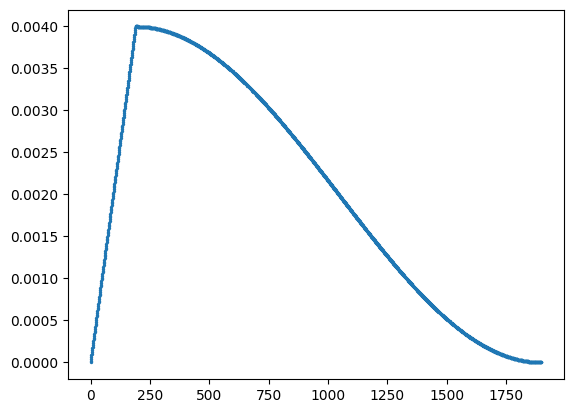


---------fold0---------
train:2523 valid:1410

Epoch 1/100


2024-10-06 02:16:01.103158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.
2024-10-06 02:16:05.051386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.


19/19 [==============================] - ETA: 0s - loss: 237.2706 - att_decoder_loss: 47.4898 - ctc_decoder_loss: 806.6132 - att_decoder_acc: 0.0272

2024-10-06 02:17:40.223486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-10-06 02:17:40.414680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


19/19 [==============================] - 224s 2s/step - loss: 237.2706 - att_decoder_loss: 47.4898 - ctc_decoder_loss: 806.6131 - att_decoder_acc: 0.0272 - val_loss: 121.3848 - val_att_decoder_loss: 35.6154 - val_ctc_decoder_loss: 378.6929 - val_att_decoder_acc: 0.1277
Epoch 2/100
19/19 [==============================] - 17s 940ms/step - loss: 45.6546 - att_decoder_loss: 35.0712 - ctc_decoder_loss: 77.4047 - att_decoder_acc: 0.1420 - val_loss: 34.5547 - val_att_decoder_loss: 32.4069 - val_ctc_decoder_loss: 40.9980 - val_att_decoder_acc: 0.1135
Epoch 3/100
19/19 [==============================] - 15s 830ms/step - loss: 34.1690 - att_decoder_loss: 31.3369 - ctc_decoder_loss: 42.6653 - att_decoder_acc: 0.2035 - val_loss: 33.4962 - val_att_decoder_loss: 31.3671 - val_ctc_decoder_loss: 39.8834 - val_att_decoder_acc: 0.1493
Epoch 4/100
19/19 [==============================] - 14s 765ms/step - loss: 31.1791 - att_decoder_loss: 29.3785 - ctc_decoder_loss: 36.5811 - att_decoder_acc: 0.2726 - va

3it [06:38, 132.98s/it]


Target    : breach
Prediction: breach
----------------------------------------------------------------------------------------------------
Target    : indecent
Prediction: indecent
----------------------------------------------------------------------------------------------------
Target    : embolden
Prediction: embolden
----------------------------------------------------------------------------------------------------
Target    : uptown
Prediction: uptown
----------------------------------------------------------------------------------------------------
Target    : burridge
Prediction: burridge
----------------------------------------------------------------------------------------------------
Score: 0.8480
mean_dist: 1.1915

CTC EVAL


3it [05:23, 107.85s/it]


Target    : decal
Prediction: dcal
----------------------------------------------------------------------------------------------------
Target    : additive
Prediction: additive
----------------------------------------------------------------------------------------------------
Target    : zoned
Prediction: zoned
----------------------------------------------------------------------------------------------------
Target    : iroquois
Prediction: roquos
----------------------------------------------------------------------------------------------------
Target    : unsure
Prediction: unsure
----------------------------------------------------------------------------------------------------
Score: 0.7668
mean_dist: 1.8284


In [26]:
CFG.resume = 'auto'
train_folds(CFG, [0])